In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive

Mounted at /content/drive
/content/drive/My Drive


In [2]:
import requests

In [3]:
from PIL import Image
import os
import zipfile
import shutil
import requests
import time
import threading
import uuid

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
def download_image(url, index, folder):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            # Ensure the folder exists
            os.makedirs(folder, exist_ok=True)
            # Save the image
            with open(f"{folder}/{index}.jpg", "wb") as f:
                f.write(response.content)
                print(f"Downloaded image {index}")
        else:
            print(f"Failed to download image {index}. Status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image {index}: {e}")

class UnsplashImageDownloader:
    def __init__(self, query):
        self.querystring = {"query": f"{query}", "per_page": "20"}
        self.headers = {
            "cookie": "require_cookie_consent=false; xp-no-ads-in-wp-search=control; xp-new-plus-algorithm=experiment; uuid=34d3cd5d-c3f3-48db-85e1-75e7d82cf1fa; azk=34d3cd5d-c3f3-48db-85e1-75e7d82cf1fa; azk-ss=true; xp-plus-offset=control; xp-semantic-related=control; xp-sidebar=experiment; _sp_ses.0295=*; _ga=GA1.2.775378564.1749664562; auth_user_id=18268125; _gid=GA1.2.654636132.1749665154; _ga_21SLH4J369=GS2.2.s1749664562$o1$g1$t1749665583$j60$l0$h0; un_sesh=NHRTcHZRWHJXSFAzSXJUMnBOVDRwNlRpR0FKRXJtQ0wyRUxiOXQ5T3liT0ZrdzJFV0JiYnBBNVVzQlFwbGJvSXYxZUZUZGNWSVlEaXQzTXFyenhFQzQ3aFErelA0ZkVqcFBWZzM2Y1VqOXRJNzJnS2hGUDJCMzExNVhjTXBkL1ZnR2NJRDU4ekptbU0wSnNyTW9wVGluNExiblpkdGU2TnB0ZllGeDNNVEkrQ3FzdjFiWHNVNlgxWWdCdVdwQ2VzZ1c0M3ZvY0hXemNXRHBUNm0ya2NwSDFUTURIY1NFYitLc3Rsbk8yYlRNSlBOMHg4TGJsOTY4WitTSXc1dzN5djUxZ09JRnpOUitGUXVXT1o5YmJZclhCUzk4QWFTTVppaGIwdzFtMEVYZGJWV1M5cjJLWEE2OXJvYzAvNXhhWDRmTDJLSStCdkZoZ3lxL0dmNnBIdTRwMm5BT0RZamxYRGF5UFM2YVE0UU5xbUFzanR5TEtmK25kZTdhandjeUtOa2ZQTTlBYTExTDUrYkRaY2tSVTl6OWRJUVgxUnhnWTlMWFk0MUtVSzA4RmthUzkrR0k1c0Jlc2JOLzd3VXFoWSs3RUIxUXZxdlFrMlNhRElWTnRCYXBlRURRYlo1Z29IRTBLNXBpQ2dhY1p5UVVJRExmc205am1lMVJtVndibVlndnlUd3B3Y3lnMkNqNWVjUzFKYjAzOUhneUI4NjZoblJnWGU2VkxVeDMxSFpnU0tmTzFpMlY4Q0dkdHBFMmRHZ2RrYjdBK012MVhKdENEblY5TlNNc2JFQUhzbUx0ZE9ITUdQTFY3VmFpclRwRlpaWlE4Q2FKYndrVzhUTHZCWVE2QmpKYytIakNDQVZtTms0aXh4ZEE9PS0tS2RGRnhSZjBma2RNRzZmMUppMjZDQT09--10f92b8e02c68c05e247601759f62c0b28904f78; _dd_s=aid=2rexuwhcl0&logs=1&id=243d4c5c-b803-4d4b-bdca-c24ed76d4bf0&created=1749664119028&expire=1749666643856; _sp_id.0295=e3cc9701-8d95-4fc6-9e2c-5e4628abc839.1744933095.4.1749665744.1749636278.486a60e6-1c1e-4c02-a91e-a3c59ed7d675..381646e2-0c39-4d2c-ae1a-8ebee78b6b86.1749665655228.10",
            "User-Agent": "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Mobile Safari/537.36",
            "Accept": "*/*",
            "Accept-Language": "en-US",
            "Referer": "https://unsplash.com/s/photos/shiba-inu"
            }
        self.url = "https://unsplash.com/napi/search/photos"

    def get_total_images(self): # <-- ONLY THIS ONE SHOULD REMAIN
        with requests.request("GET", self.url, headers=self.headers, params=self.querystring) as rs:
            print("DEBUG: get_total_images Status Code:", rs.status_code) # Keep this!
            print("DEBUG: get_total_images Response Text (first 500 chars):", rs.text[:500]) # Keep this!
            json_data = rs.json()
        return json_data["total"]

    def get_links(self, pages_, quality_):
        all_links = []
        for page in range(1, int(pages_) + 1):
            self.querystring["page"] = f"{page}"

            response = requests.request("GET", self.url, headers=self.headers, params=self.querystring)
            print(f"Status Code for page {page}:", response.status_code) # ADD THIS
            print(f"Response Text for page {page} (first 500 chars):", response.text[:500]) # ADD THIS
            response_json = response.json()
            all_data = response_json["results"]

            for data in all_data:
                name = None
                try:
                    if data.get("sponsorship") and data["sponsorship"].get("tagline"):
                        name = data["sponsorship"]["tagline"]
                except KeyError:
                    pass
                if not name:
                    try:
                        name = data.get('alt_description', '')
                    except KeyError:
                        pass
                if not name:
                    name = data.get('description', '')

                try:
                    image_urls = data["urls"]
                    required_link = image_urls[quality_]
                    print("name     : ", name)
                    print(f"url : {required_link}\n")
                    all_links.append(required_link)
                except KeyError:
                    pass

        return all_links


if __name__ == '__main__':
    folder = "shiba inu"
    if not os.path.exists(folder):
        os.mkdir(folder)

    search = input("What you want to search for? ")

    unsplash = UnsplashImageDownloader(search)

    total_image = unsplash.get_total_images()
    print("\ntotal images available : ", total_image)

    if total_image == 0:
        print("Sorry, no image available for this search")
        exit()

    number_of_images_str = input("Enter number of images you want to download: ")

    # Remove commas from the input string
    number_of_images_str = number_of_images_str.replace(",", "")

    try:
        number_of_images = int(number_of_images_str)
    except ValueError:
        print("Invalid input. Please enter a valid number.")
        exit()

    if number_of_images == 0 or number_of_images > total_image:
        print("Not a valid number")
        exit()

    pages = float(number_of_images / 20)
    if pages != int(pages):
        pages = int(pages) + 1

    print("\nAvailable image quality:\nraw\nfull\nregular\nsmall\nthumb\nsmall_s3\n")

    quality = input("Enter the quality: ")
    image_links = unsplash.get_links(pages, quality)

    start = time.time()
    print("Download started....\n")

    # Download images
    threads = []
    index = 1
    for url in image_links:
        t = threading.Thread(target=download_image, args=(url, index, folder))
        threads.append(t)
        t.start()
        index += 1

    for thread in threads:
        thread.join()

    print("\nDownloading finished.")
    print("Time taken: ", time.time() - start)


What you want to search for? shiba inu
DEBUG: get_total_images Status Code: 403
DEBUG: get_total_images Response Text (first 500 chars): 


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
!ls "/content/drive/MyDrive"

'Colab Notebooks'
 Dog_Dataset
 Dog_standardised
'no no only 1 slide.gsheet'
'ok so what i need to do is '$'\n\n'' Risk Determination.gsheet'
'shiba inu'
'wait here some details'$'\n\n''"Present the findings in....gsheet'
'Zoom recording'


In [ ]:
!unzip /content/drive/MyDrive/Dog_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dog_Dataset/val/5/1065.jpg  
  inflating: Dog_Dataset/val/5/1814.jpg  
  inflating: Dog_Dataset/train/1/630.jpg  
  inflating: Dog_Dataset/val/5/946.jpg  
  inflating: Dog_Dataset/val/5/2682.jpg  
  inflating: Dog_Dataset/val/5/1363.jpg  
  inflating: Dog_Dataset/val/5/2200.jpg  
  inflating: Dog_Dataset/train/1/1298.jpg  
  inflating: Dog_Dataset/train/1/1228.jpg  
  inflating: Dog_Dataset/train/1/2371.jpg  
  inflating: Dog_Dataset/val/5/1911.jpg  
  inflating: Dog_Dataset/val/5/2126.jpg  
  inflating: Dog_Dataset/val/5/2240.jpg  
  inflating: Dog_Dataset/val/5/1600.jpg  
  inflating: Dog_Dataset/train/1/447.jpg  
  inflating: Dog_Dataset/train/1/357.jpg  
  inflating: Dog_Dataset/train/1/275.jpg  
  inflating: Dog_Dataset/val/5/2075.jpg  
  inflating: Dog_Dataset/train/1/12.jpg  
  inflating: Dog_Dataset/val/5/1054.jpg  
  inflating: Dog_Dataset/train/1/1113.jpg  
  inflating: Dog_Dataset/val/5/278.jpg  
  inflating: Do

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_dir):
    X = []  # List to store image paths
    y = []  # List to store corresponding labels

    print(f"DEBUG: Checking root directory: {root_dir}")
    if not os.path.exists(root_dir):
        print(f"DEBUG: Root directory DOES NOT EXIST: {root_dir}")
        return np.array(X), np.array(y)
    if not os.path.isdir(root_dir):
        print(f"DEBUG: Root path is not a directory: {root_dir}")
        return np.array(X), np.array(y)

    # Iterate through each class folder
    class_folders = sorted(os.listdir(root_dir))
    print(f"DEBUG: Found {len(class_folders)} items in root directory.")
    if not class_folders:
        print(f"DEBUG: No class folders found in {root_dir}")

    for class_idx, class_name in enumerate(class_folders):
        class_dir = os.path.join(root_dir, class_name)
        print(f"DEBUG: Processing class directory: {class_dir}")
        if os.path.isdir(class_dir):
            images_in_class = os.listdir(class_dir)
            print(f"DEBUG: Found {len(images_in_class)} items in {class_dir}")
            if not images_in_class:
                print(f"DEBUG: No images found in {class_dir}")

            for image_name in images_in_class:
                image_path = os.path.join(class_dir, image_name)
                # Add a check for common image extensions if needed,
                # though os.path.isfile is usually enough
                if os.path.isfile(image_path) and (image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))): # Added extension check
                    X.append(image_path)
                    y.append(class_idx)  # Assigning label based on folder index
                else:
                    print(f"DEBUG: Skipping non-image file or directory: {image_path}")
        else:
            print(f"DEBUG: Skipping non-directory item in root: {class_dir}")

    print(f"DEBUG: load_data completed. Total images loaded: {len(X)}")
    return np.array(X), np.array(y)

def save_splits(root_dir, X_train, X_val, X_test, y_train, y_val, y_test):
    splits = {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }

    for split_name, (X_split, y_split) in splits.items():
        split_dir = os.path.join(root_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)

        for image_path, label in zip(X_split, y_split):
            # Get class directory based on label
            class_dir = os.path.join(split_dir, str(label))
            os.makedirs(class_dir, exist_ok=True)

            # Copy image file to the class directory
            try:
                image_name = os.path.basename(image_path)
                shutil.copy(image_path, os.path.join(class_dir, image_name))
            except Exception as e:
                print(f"Error copying {image_path} to {class_dir}: {e}")

# Define your directories
root_directory_standardised = '/content/drive/My Drive/Dog_standardised/'
root_directory_dataset = '/content/drive/My Drive/Dog_Dataset/'

# Load data paths and labels
X, y = load_data(root_directory_standardised)

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print sizes of each set
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

# Save splits into separate directories within Dog_Dataset
save_splits(root_directory_dataset, X_train, X_val, X_test, y_train, y_val, y_test)

print("Splits saved successfully.")

In [ ]:
unique_labels = np.unique(y)
print(f"Unique labels: {unique_labels}")

In [ ]:
train_path = '/content/drive/My Drive/Dog_Dataset/train'
valid_path = '/content/drive/My Drive/Dog_Dataset/val'
test_path = '/content/drive/My Drive/Dog_Dataset/test'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug'], batch_size = 32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug'], batch_size = 32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=['beagle','bulldog','chihuahua','dalmatian','golden retriever','labrador','poodle','pug'], batch_size = 32, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot images from a batch
def plot_images(batch, num_images=5):
    # Get a batch of images and labels
    images, labels = next(batch)

    # Plot the images
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title('Label: ' + str(labels[i]))
        plt.axis('off')
    plt.show()

# Plot images from train_batches
print("Training batch:")
plot_images(train_batches)

# Plot images from valid_batches
print("Validation batch:")
plot_images(valid_batches)

# Plot images from test_batches
print("Test batch:")
plot_images(test_batches)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Example of loading dataset (adjust paths and parameters accordingly)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5851 images belonging to 7 classes.
Found 1758 images belonging to 7 classes.
Found 1864 images belonging to 7 classes.


In [ ]:
import os
from PIL import Image

def verify_and_delete_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify if the file is an image
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted file: {file_path} - {e}")
                os.remove(file_path)

# Replace 'path_to_train_directory' with your actual path
verify_and_delete_images('/content/drive/MyDrive/Dog_Dataset/train')
verify_and_delete_images('/content/drive/MyDrive/Dog_Dataset/val')
verify_and_delete_images('/content/drive/MyDrive/Dog_Dataset/test')


Deleting corrupted file: /content/drive/MyDrive/Dog_Dataset/train/6/1343.jpg - cannot identify image file '/content/drive/MyDrive/Dog_Dataset/train/6/1343.jpg'
Deleting corrupted file: /content/drive/MyDrive/Dog_Dataset/test/6/1400.jpg - cannot identify image file '/content/drive/MyDrive/Dog_Dataset/test/6/1400.jpg'


In [ ]:
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import os

# Check if validation set is missing any classes from the training set
train_dir = '/content/drive/MyDrive/Dog_Dataset/train'
valid_dir = '/content/drive/MyDrive/Dog_Dataset/val'
test_dir = '/content/drive/MyDrive/Dog_Dataset/test'

train_classes = set(os.listdir(train_dir))
valid_classes = set(os.listdir(valid_dir))
test_classes = set(os.listdir(test_dir))

missing_in_valid = train_classes - valid_classes
missing_in_test = train_classes - test_classes

print("Missing in validation set:", missing_in_valid)
print("Missing in test set:", missing_in_test)

import shutil

# Automatically create missing folders and copy a few images
for cls in missing_in_test:
    src_class_dir = os.path.join(train_dir, cls)
    dst_class_dir = os.path.join(test_dir, cls)

    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        print(f"Created folder for missing class in test: {dst_class_dir}")

        # Copy up to 10 images from train to test
        images = os.listdir(src_class_dir)
        for img in images[:10]:
            shutil.copy2(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

        print(f"Copied {min(10, len(images))} images to {dst_class_dir}")

# Automatically create missing folders and copy a few images
for cls in missing_in_valid:
    src_class_dir = os.path.join(train_dir, cls)
    dst_class_dir = os.path.join(valid_dir, cls)

    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        print(f"Created folder for missing class: {dst_class_dir}")

        # Copy up to 10 images from train to val
        images = os.listdir(src_class_dir)
        for idx, img in enumerate(images[:10]):  # Copy 10 images max
            shutil.copy2(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

        print(f"Copied {min(10, len(images))} images to {dst_class_dir}")

# Define functions to build models (ResNet50, DenseNet121, MobileNetV3)
def build_resnet50(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_densenet121(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenetv3(num_classes):
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/train',       # or the actual path to your unzipped training folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dog_Dataset/val',       # or the actual path to your unzipped validation folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print(train_generator.class_indices)
# Initialize models
num_classes = len(train_generator.class_indices)
resnet_model = build_resnet50(num_classes)
densenet_model = build_densenet121(num_classes)
mobilenet_model = build_mobilenetv3(num_classes)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Custom training function to handle missing files
def safe_fit(model, train_generator, valid_generator, epochs, callbacks):
    while True:
        try:
            history = model.fit(
                train_generator,
                validation_data=valid_generator,
                epochs=epochs,
                callbacks=callbacks
            )
            return history
        except FileNotFoundError as e:
            print(f"Skipping missing file during training: {e}")
            continue





Missing in validation set: set()
Missing in test set: set()
Found 5851 images belonging to 7 classes.
Found 1758 images belonging to 7 classes.
{'0': 0, '1': 1, '2': 2, '4': 3, '5': 4, '6': 5, '7': 6}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train ResNet50
print("Training ResNet50...")
history_resnet = safe_fit(
    resnet_model,
    train_generator,
    valid_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Create a directory to save the models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the models in the specified directory
resnet_model.save(os.path.join(save_dir, 'resnet50_model.keras'))

# Save the training histories
with open(os.path.join(save_dir, 'resnet50_history.json'), 'w') as f:
    json.dump(history_resnet.history, f)

Training ResNet50...
Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 123s 613ms/step - accuracy: 0.2848 - loss: 1.9662 - val_accuracy: 0.3003 - val_loss: 1.8600
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 102s 559ms/step - accuracy: 0.3252 - loss: 1.7685 - val_accuracy: 0.3669 - val_loss: 1.9050
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 142s 557ms/step - accuracy: 0.3275 - loss: 1.7556 - val_accuracy: 0.3709 - val_loss: 1.7447
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 101s 549ms/step - accuracy: 0.3394 - loss: 1.7335 - val_accuracy: 0.3703 - val_loss: 1.7741
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 143s 553ms/step - accuracy: 0.3374 - loss: 1.7353 - val_accuracy: 0.3663 - val_loss: 1.7174
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 101s 551ms/step - accuracy: 0.3352 - loss: 1.7416 - val_accuracy: 0.3493 - val_loss: 1.8264
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 101s 554ms/step - accuracy: 0.3419 - loss: 1.7165 - val_accuracy: 0.3601 - val_loss: 1.7547
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 141s 549ms/step

In [ ]:
# Train DenseNet121
print("Training DenseNet121...")
history_densenet = safe_fit(
    densenet_model,
    train_generator,
    valid_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Create a directory to save the models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the models in the specified directory
densenet_model.save(os.path.join(save_dir, 'densenet121_model.keras'))

# Save the training histories
with open(os.path.join(save_dir, 'densenet121_history.json'), 'w') as f:
    json.dump(history_densenet.history, f)

Training DenseNet121...
Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 167s 754ms/step - accuracy: 0.6216 - loss: 1.1277 - val_accuracy: 0.7895 - val_loss: 0.5847
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 101s 554ms/step - accuracy: 0.7508 - loss: 0.7110 - val_accuracy: 0.7338 - val_loss: 0.7788
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 100s 548ms/step - accuracy: 0.7505 - loss: 0.6876 - val_accuracy: 0.7747 - val_loss: 0.6637
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 102s 554ms/step - accuracy: 0.7940 - loss: 0.5864 - val_accuracy: 0.7702 - val_loss: 0.6717
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 102s 556ms/step - accuracy: 0.7802 - loss: 0.6127 - val_accuracy: 0.8038 - val_loss: 0.6217
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 101s 553ms/step - accuracy: 0.7913 - loss: 0.5649 - val_accuracy: 0.7514 - val_loss: 0.7324
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 143s 557ms/step - accuracy: 0.8018 - loss: 0.5373 - val_accuracy: 0.7730 - val_loss: 0.6784
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 105s 574ms/s

In [ ]:
# Train MobileNetV3
print("Training MobileNetV3...")
history_mobilenet = safe_fit(
    mobilenet_model,
    train_generator,
    valid_generator,
    epochs=50,
    callbacks=[early_stopping]
)

# Create a directory to save the models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the models in the specified directory
mobilenet_model.save(os.path.join(save_dir, 'mobilenetv3_model.keras'))

# Save the training histories
with open(os.path.join(save_dir, 'mobilenetv3_history.json'), 'w') as f:
    json.dump(history_mobilenet.history, f)

Training MobileNetV3...
Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 59s 257ms/step - accuracy: 0.2720 - loss: 1.8446 - val_accuracy: 0.3157 - val_loss: 1.8216
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 32s 175ms/step - accuracy: 0.3103 - loss: 1.7644 - val_accuracy: 0.3436 - val_loss: 1.7698
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 31s 170ms/step - accuracy: 0.3232 - loss: 1.7504 - val_accuracy: 0.2838 - val_loss: 1.8133
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 31s 168ms/step - accuracy: 0.3102 - loss: 1.7611 - val_accuracy: 0.3623 - val_loss: 1.7390
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 35s 190ms/step - accuracy: 0.3166 - loss: 1.7445 - val_accuracy: 0.3373 - val_loss: 1.7713
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 32s 172ms/step - accuracy: 0.3114 - loss: 1.7510 - val_accuracy: 0.3612 - val_loss: 1.7416
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.3222 - loss: 1.7393 - val_accuracy: 0.3618 - val_loss: 1.7466
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - ac

In [ ]:
# List the saved models
!ls -lh saved_models/

total 179M
-rw------- 1 root root  936 Jun 11 20:13 densenet121_history.json
-rw------- 1 root root  41M Jun 11 20:13 densenet121_model.keras
-rw------- 1 root root 1.2K Jun 11 20:26 mobilenetv3_history.json
-rw------- 1 root root  24M Jun 11 20:26 mobilenetv3_model.keras
-rw------- 1 root root 1.3K Jun 11 19:50 resnet50_history.json
-rw------- 1 root root 115M Jun 11 19:50 resnet50_model.keras


In [ ]:
# Evaluate ResNet50
resnet_eval = resnet_model.evaluate(test_generator)
resnet_predictions = resnet_model.predict(test_generator)

# Evaluate DenseNet121
densenet_eval = densenet_model.evaluate(test_generator)
densenet_predictions = densenet_model.predict(test_generator)

# Evaluate MobileNetV3
mobilenet_eval = mobilenet_model.evaluate(test_generator)
mobilenet_predictions = mobilenet_model.predict(test_generator)

# Example printout of evaluation metrics
print("ResNet50 - Loss: {:.4f}, Accuracy: {:.4f}".format(resnet_eval[0], resnet_eval[1]))
print("DenseNet121 - Loss: {:.4f}, Accuracy: {:.4f}".format(densenet_eval[0], densenet_eval[1]))
print("MobileNetV3 - Loss: {:.4f}, Accuracy: {:.4f}".format(mobilenet_eval[0], mobilenet_eval[1]))


59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.1298 - loss: 1.8094
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - accuracy: 0.0910 - loss: 2.2861
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - accuracy: 1.9679e-04 - loss: 2.1640
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step
ResNet50 - Loss: 2.1402, Accuracy: 0.0317
DenseNet121 - Loss: 2.2699, Accuracy: 0.0837
MobileNetV3 - Loss: 2.1513, Accuracy: 0.0054


In [ ]:
# Print model summaries
print("🔍 ResNet50 Model Summary:")
resnet_model.summary()

print("\n🔍 DenseNet121 Model Summary:")
densenet_model.summary()

print("\n🔍 MobileNetV3 Model Summary:")
mobilenet_model.summary()

# Function to inspect final Dense layer info
def inspect_final_layer(model, model_name):
    final_layer = model.layers[-1]
    print(f"\n🧪 {model_name} Final Layer:")
    print(final_layer)

    # Check if it's a Dense layer
    if hasattr(final_layer, 'units') and hasattr(final_layer, 'activation'):
        print(f"  - Units: {final_layer.units}")
        print(f"  - Activation: {final_layer.activation.__name__}")
    else:
        print("  ⚠️ Final layer is not a Dense layer or lacks units/activation info.")

# Check final layers
inspect_final_layer(resnet_model, "ResNet50")
inspect_final_layer(densenet_model, "DenseNet121")
inspect_final_layer(mobilenet_model, "MobileNetV3")

# (Optional) Show class count for verification
print("\n📦 Class count in training set:", len(train_generator.class_indices))
print("Class labels:", list(train_generator.class_indices.keys()))


🔍 ResNet50 Model Summary:


Model: "functional"

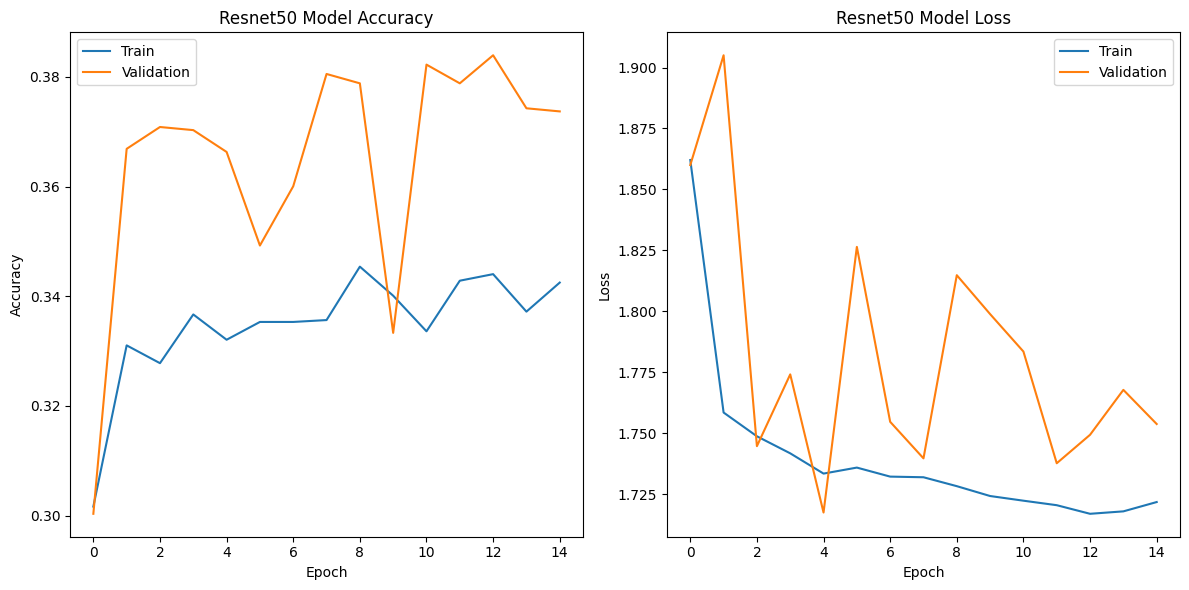

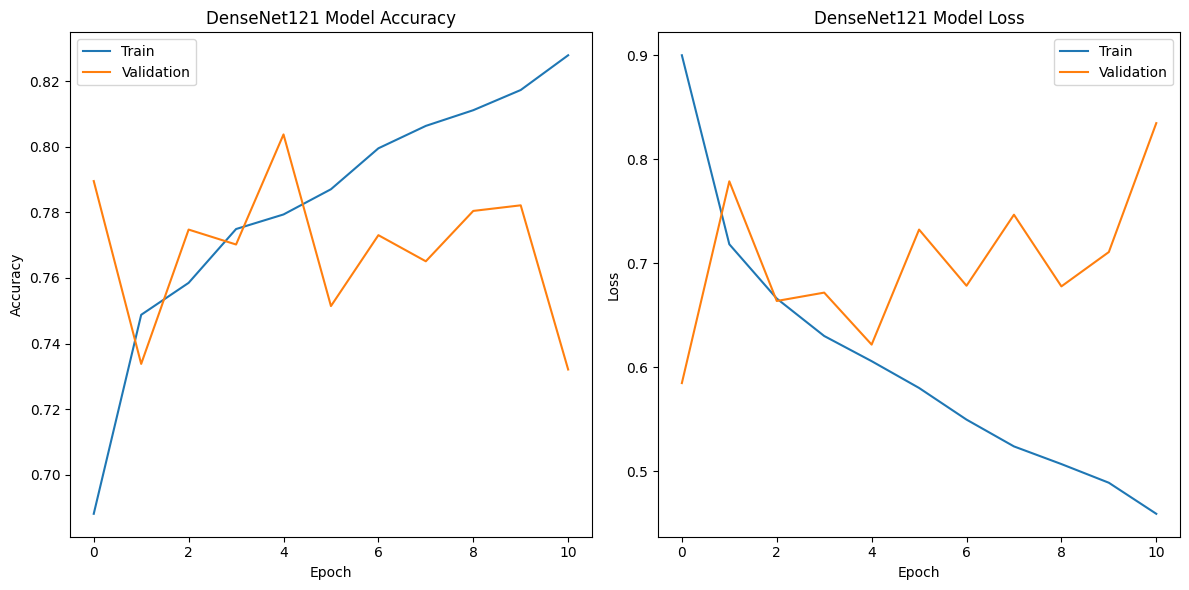

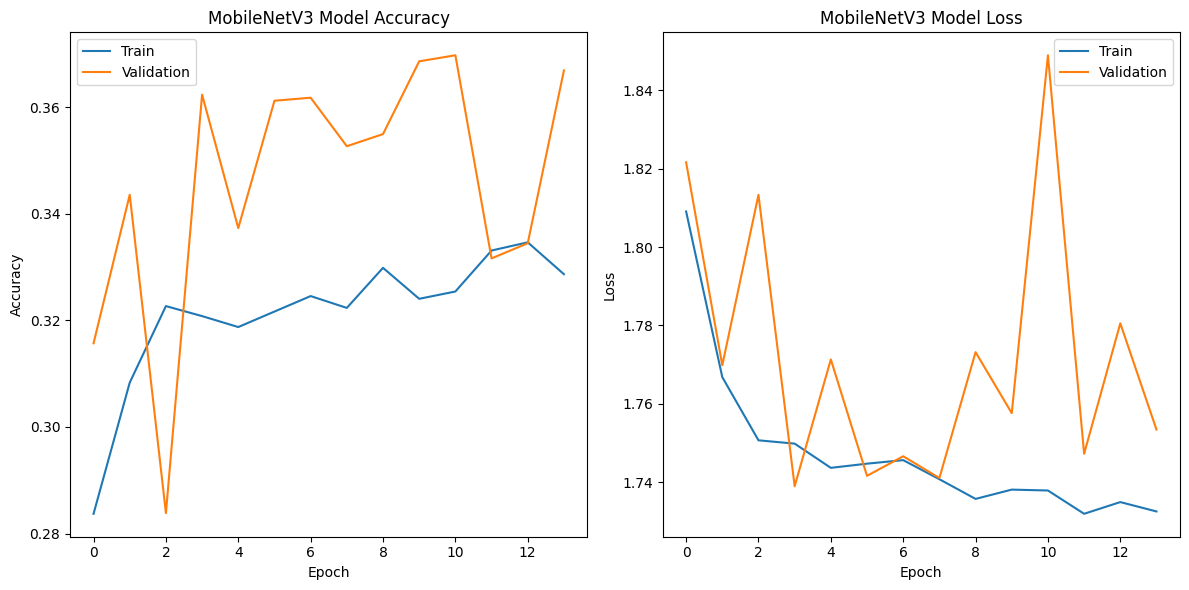

In [ ]:
# 1. Show Graphs for Model Loss and Accuracy

import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have histories for each model
histories = {
    'Resnet50': history_resnet,
    'DenseNet121': history_densenet,
    'MobileNetV3': history_mobilenet,
}

for model_name, history in histories.items():
    plot_training_history(history, model_name)


59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step


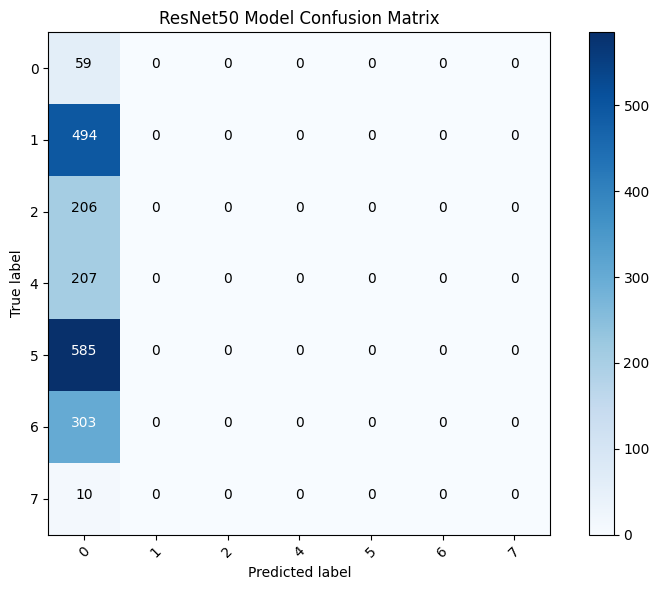


Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.03      1.00      0.06        59
           1       0.00      0.00      0.00       494
           2       0.00      0.00      0.00       206
           4       0.00      0.00      0.00       207
           5       0.00      0.00      0.00       585
           6       0.00      0.00      0.00       303
           7       0.00      0.00      0.00        10

    accuracy                           0.03      1864
   macro avg       0.00      0.14      0.01      1864
weighted avg       0.00      0.03      0.00      1864



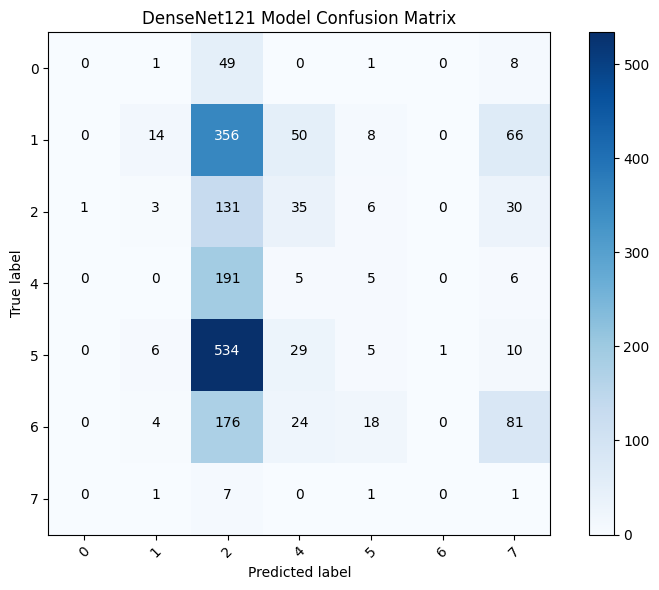


Classification Report for DenseNet121:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.48      0.03      0.05       494
           2       0.09      0.64      0.16       206
           4       0.03      0.02      0.03       207
           5       0.11      0.01      0.02       585
           6       0.00      0.00      0.00       303
           7       0.00      0.10      0.01        10

    accuracy                           0.08      1864
   macro avg       0.10      0.11      0.04      1864
weighted avg       0.18      0.08      0.04      1864



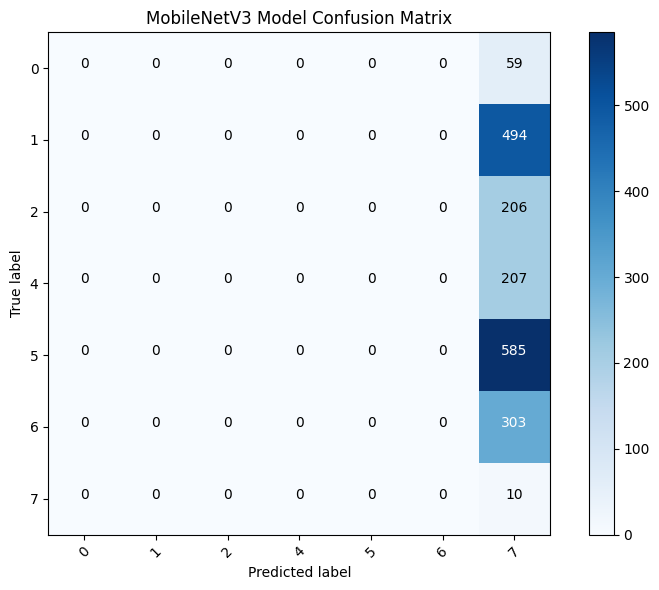


Classification Report for MobileNetV3:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.00      0.00      0.00       494
           2       0.00      0.00      0.00       206
           4       0.00      0.00      0.00       207
           5       0.00      0.00      0.00       585
           6       0.00      0.00      0.00       303
           7       0.01      1.00      0.01        10

    accuracy                           0.01      1864
   macro avg       0.00      0.14      0.00      1864
weighted avg       0.00      0.01      0.00      1864



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Model Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Get true labels from test generator
test_generator.reset()
true_labels = np.argmax(np.vstack([test_generator[i][1] for i in range(len(test_generator))]), axis=1)

# Predict with each model
predictions = {}
for model_name, model in {
    'ResNet50': resnet_model,
    'DenseNet121': densenet_model,
    'MobileNetV3': mobilenet_model
}.items():
    test_generator.reset()
    predictions[model_name] = model.predict(test_generator)

# Plot confusion matrix and classification report
for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    plot_confusion_matrix(true_labels, y_pred_classes, classes=list(test_generator.class_indices.keys()), model_name=model_name)
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(
        true_labels,
        y_pred_classes,
        target_names=list(test_generator.class_indices.keys()),
        zero_division=0  # <- This handles undefined metrics gracefully
    ))

59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step


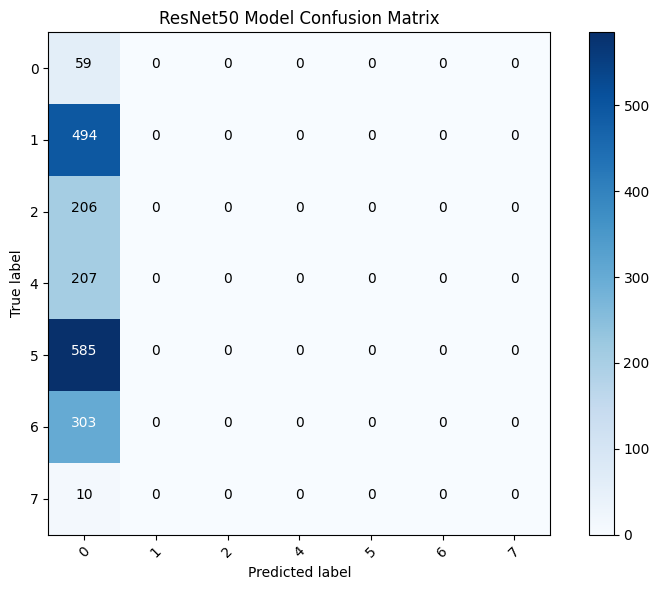


Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.03      1.00      0.06        59
           1       0.00      0.00      0.00       494
           2       0.00      0.00      0.00       206
           4       0.00      0.00      0.00       207
           5       0.00      0.00      0.00       585
           6       0.00      0.00      0.00       303
           7       0.00      0.00      0.00        10

    accuracy                           0.03      1864
   macro avg       0.00      0.14      0.01      1864
weighted avg       0.00      0.03      0.00      1864



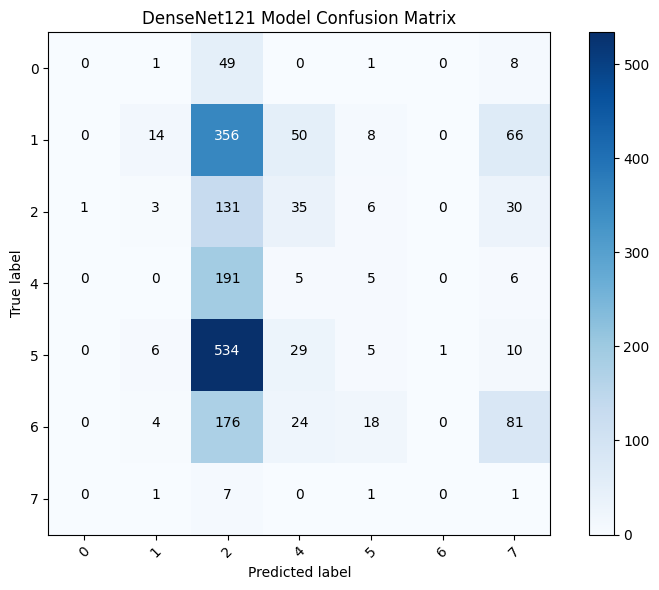


Classification Report for DenseNet121:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.48      0.03      0.05       494
           2       0.09      0.64      0.16       206
           4       0.03      0.02      0.03       207
           5       0.11      0.01      0.02       585
           6       0.00      0.00      0.00       303
           7       0.00      0.10      0.01        10

    accuracy                           0.08      1864
   macro avg       0.10      0.11      0.04      1864
weighted avg       0.18      0.08      0.04      1864



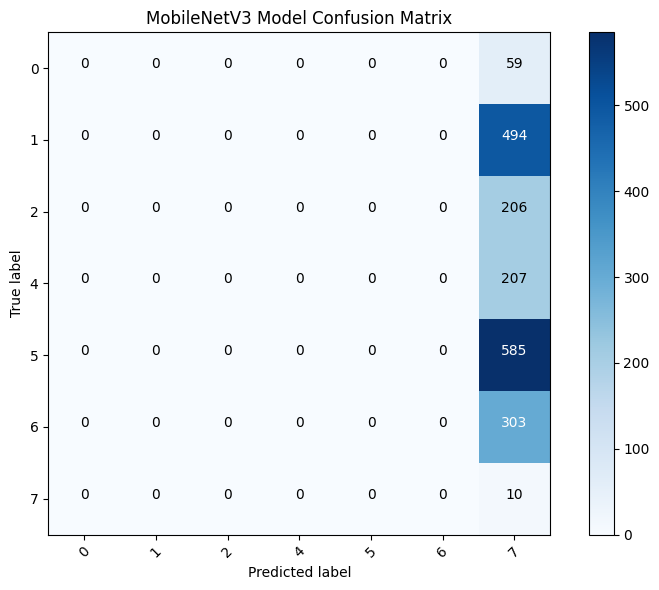


Classification Report for MobileNetV3:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.00      0.00      0.00       494
           2       0.00      0.00      0.00       206
           4       0.00      0.00      0.00       207
           5       0.00      0.00      0.00       585
           6       0.00      0.00      0.00       303
           7       0.01      1.00      0.01        10

    accuracy                           0.01      1864
   macro avg       0.00      0.14      0.00      1864
weighted avg       0.00      0.01      0.00      1864

ResNet50 - Accuracy: 0.0317, Precision: 0.0045, Recall: 0.1429, F1 Score: 0.0088
DenseNet121 - Accuracy: 0.0837, Precision: 0.1039, Recall: 0.1139, F1 Score: 0.0380
MobileNetV3 - Accuracy: 0.0054, Precision: 0.0008, Recall: 0.1429, F1 Score: 0.0015

✅ The best model for this classification task is **DenseNet121**.


In [ ]:
# 1. Import libraries
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools



# 2. Reset test generator and get true labels
test_generator.reset()
true_labels = np.argmax(np.vstack([test_generator[i][1] for i in range(len(test_generator))]), axis=1)

# 3. Make predictions for each model
predictions = {}
for model_name, model in {
    'ResNet50': resnet_model,
    'DenseNet121': densenet_model,
    'MobileNetV3': mobilenet_model
}.items():
    test_generator.reset()
    predictions[model_name] = model.predict(test_generator)

# 4. Plot confusion matrices + classification reports for each model
for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    plot_confusion_matrix(true_labels, y_pred_classes, classes=list(test_generator.class_indices.keys()), model_name=model_name)
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(true_labels, y_pred_classes, target_names=list(test_generator.class_indices.keys()), zero_division=0))

# 5. ADD PERFORMANCE COMPARISON CODE

model_performance = {}

for model_name, y_pred in predictions.items():
    y_pred_classes = np.argmax(y_pred, axis=1)
    report = classification_report(
        true_labels,
        y_pred_classes,
        target_names=list(test_generator.class_indices.keys()),
        output_dict=True,
        zero_division=0  # Suppress warnings and set precision=0 for undefined cases
    )

    # Compute average precision/recall/f1 from per-class metrics
    precision = np.mean([report[label]['precision'] for label in test_generator.class_indices.keys()])
    recall = np.mean([report[label]['recall'] for label in test_generator.class_indices.keys()])
    f1_score = np.mean([report[label]['f1-score'] for label in test_generator.class_indices.keys()])
    accuracy = report['accuracy']

    model_performance[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

# 7. Print comparison and find the best model
for model_name, metrics in model_performance.items():
    print(f"{model_name} - Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}")

best_model = max(model_performance, key=lambda k: model_performance[k]['f1_score'])
print(f"\n✅ The best model for this classification task is **{best_model}**.")
